### 데이터 로딩

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

In [4]:
data = pd.read_csv('./data/energy.csv')
data.head()

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000
3,2012-01-01 03:00:00,2402.0,31.000000
4,2012-01-01 04:00:00,2403.0,32.000000


In [5]:
data.tail()

,timestamp,load,temp
26299,2014-12-31 19:00:00,4012.0,18.000000
26300,2014-12-31 20:00:00,3856.0,16.666667
26301,2014-12-31 21:00:00,3671.0,17.000000
26302,2014-12-31 22:00:00,3499.0,15.333333
26303,2014-12-31 23:00:00,3345.0,15.333333


In [6]:
data.shape

(26304, 3)

2012년, 2013년, 2014년 3년간의 에너지 사용량 데이터

#### 시계열 데이터를 파싱해서 데이터 로딩

In [7]:
energy = pd.read_csv('./data/energy.csv',
                     parse_dates=['timestamp'],
                     index_col='timestamp')
energy.head()

,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000
2012-01-01 03:00:00,2402.0,31.000000
2012-01-01 04:00:00,2403.0,32.000000


### 1. 과거의 load를 이용해서 다음 load를 예측해보자.

In [8]:
# 현재 사용하지 않는 temp는 삭제
del energy['temp']

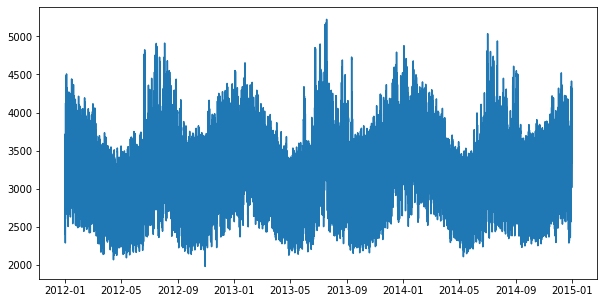

In [9]:
plt.figure(figsize=(10,5))
plt.plot(energy)
plt.show()

#### 데이터 탐색 포인트
- 여름, 겨울시기에 에너지 사용량이 증가하는 패턴을 보인다.
- 시계열 데이터는 시간의 순서가 섞이면 안된다. 랜덤 샘플링이 아니라 순서대로 훈련, 검증, 테스트 데이터를 쪼겐다.
- 최적의 가중치, 절편으로 수렴하기 위해 정답 데이터를 정규화하는편이다.
- 학습할때는 정규화된 데이터를 이용하고 예측해서 서비스로 제공할때는 원래 단위로 복원하는 작업을 진행한다.

### 데이터 전처리

#### 1. 데이터 스케일링(정규화)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
scaler.fit(energy) #최대값, 최소값 찾기

MinMaxScaler()

In [13]:
energy['load'] = scaler.transform(energy)

In [14]:
energy.head(10)

,load
timestamp,
2012-01-01 00:00:00,0.221572
2012-01-01 01:00:00,0.178428
2012-01-01 02:00:00,0.143297
2012-01-01 03:00:00,0.130354
2012-01-01 04:00:00,0.130663
2012-01-01 05:00:00,0.146071
2012-01-01 06:00:00,0.179045
2012-01-01 07:00:00,0.228043
2012-01-01 08:00:00,0.288752


#### RNN을 위한 데이터 구조로 변경(samples, time-steps, features)

In [15]:
energy_shifted = energy.copy() # 데이터복사

In [16]:
energy_shifted['y+1'] = energy_shifted.shift(-1,freq='H')  # 음수 : 땡겨짐, 양수: 밀림
energy_shifted.head()

,load,y+1
timestamp,,
2012-01-01 00:00:00,0.221572,0.178428
2012-01-01 01:00:00,0.178428,0.143297
2012-01-01 02:00:00,0.143297,0.130354
2012-01-01 03:00:00,0.130354,0.130663
2012-01-01 04:00:00,0.130663,0.146071


In [17]:
# 과거 6시간으로 미래 1시간을 예측
energy_shifted['load_t-5'] = energy.shift(5,freq='H')
energy_shifted['load_t-4'] = energy.shift(4,freq='H')
energy_shifted['load_t-3'] = energy.shift(3,freq='H')
energy_shifted['load_t-2'] = energy.shift(2,freq='H')
energy_shifted['load_t-1'] = energy.shift(1,freq='H')
energy_shifted['load_t-0'] = energy.shift(0,freq='H')

In [18]:
energy_shifted.head(10)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,
2012-01-01 00:00:00,0.221572,0.178428,NaN,NaN,NaN,NaN,NaN,0.221572
2012-01-01 01:00:00,0.178428,0.143297,NaN,NaN,NaN,NaN,0.221572,0.178428
2012-01-01 02:00:00,0.143297,0.130354,NaN,NaN,NaN,0.221572,0.178428,0.143297
2012-01-01 03:00:00,0.130354,0.130663,NaN,NaN,0.221572,0.178428,0.143297,0.130354
2012-01-01 04:00:00,0.130663,0.146071,NaN,0.221572,0.178428,0.143297,0.130354,0.130663
2012-01-01 05:00:00,0.146071,0.179045,0.221572,0.178428,0.143297,0.130354,0.130663,0.146071
2012-01-01 06:00:00,0.179045,0.228043,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045
2012-01-01 07:00:00,0.228043,0.288752,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043
2012-01-01 08:00:00,0.288752,0.346995,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752


In [19]:
energy_shifted.tail(10)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,
2014-12-31 14:00:00,0.589831,0.595686,0.646533,0.645300,0.632049,0.617257,0.602157,0.589831
2014-12-31 15:00:00,0.595686,0.666256,0.645300,0.632049,0.617257,0.602157,0.589831,0.595686
2014-12-31 16:00:00,0.666256,0.721109,0.632049,0.617257,0.602157,0.589831,0.595686,0.666256
2014-12-31 17:00:00,0.721109,0.684129,0.617257,0.602157,0.589831,0.595686,0.666256,0.721109
2014-12-31 18:00:00,0.684129,0.626502,0.602157,0.589831,0.595686,0.666256,0.721109,0.684129
2014-12-31 19:00:00,0.626502,0.578428,0.589831,0.595686,0.666256,0.721109,0.684129,0.626502
2014-12-31 20:00:00,0.578428,0.521418,0.595686,0.666256,0.721109,0.684129,0.626502,0.578428
2014-12-31 21:00:00,0.521418,0.468413,0.666256,0.721109,0.684129,0.626502,0.578428,0.521418
2014-12-31 22:00:00,0.468413,0.420955,0.721109,0.684129,0.626502,0.578428,0.521418,0.468413


In [20]:
# 결측치 데이터 삭제
energy_shifted.dropna(inplace=True)

In [21]:
energy_shifted.tail()

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,
2014-12-31 18:00:00,0.684129,0.626502,0.602157,0.589831,0.595686,0.666256,0.721109,0.684129
2014-12-31 19:00:00,0.626502,0.578428,0.589831,0.595686,0.666256,0.721109,0.684129,0.626502
2014-12-31 20:00:00,0.578428,0.521418,0.595686,0.666256,0.721109,0.684129,0.626502,0.578428
2014-12-31 21:00:00,0.521418,0.468413,0.666256,0.721109,0.684129,0.626502,0.578428,0.521418
2014-12-31 22:00:00,0.468413,0.420955,0.721109,0.684129,0.626502,0.578428,0.521418,0.468413


#### 훈련, 검증, 테스트 데이터 분할

In [22]:
validation_start = '2014-09-01 00:00:00'  # 끝에 9월, 10월 2개월 검증용 사용
test_start = '2014-11-01 00:00:00'  # 끝에 11월, 12월 2개월 테스트용 사용

In [23]:
train = energy_shifted[energy_shifted.index < validation_start]
validation = energy_shifted[(energy_shifted.index >= validation_start) & (energy_shifted.index < test_start)]
test = energy_shifted[energy_shifted.index >= test_start]

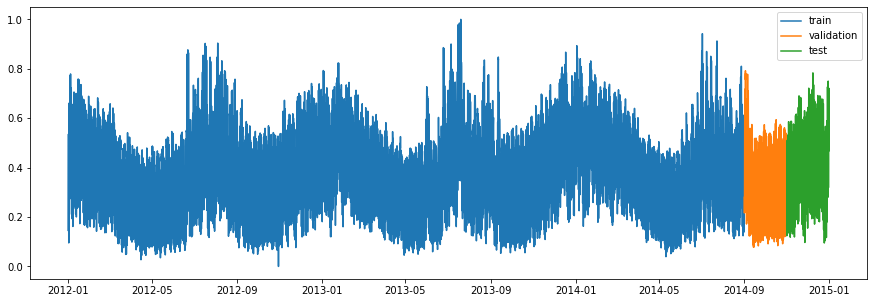

In [24]:
# 분리된 데이터 시각화
plt.figure(figsize=(15,5))
plt.plot(train['load'], label='train')
plt.plot(validation['load'], label='validation')
plt.plot(test['load'], label='test')
plt.legend()
plt.show()

In [25]:
# 훈련데이터
X_train = train.loc[:,'load_t-5':'load_t-0']
y_train = train['y+1']
# 검증데이터
X_validation = validation.loc[:,'load_t-5':'load_t-0']
y_validation = validation['y+1']
# 평가데이터
X_test = test.loc[:,'load_t-5':'load_t-0']
y_test = test['y+1']

In [26]:
# RNN을 위한 데이터 구조로 변경(samples, time-steps, features) 
X_train = X_train.values.reshape(-1,6,1)
X_validation = X_validation.values.reshape(-1,6,1)
X_test = X_test.values.reshape(-1,6,1)

### 모델링

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM

In [28]:
model=Sequential()

model.add(InputLayer(input_shape=(6,1)))
model.add(LSTM(64))
model.add(Dense(1)) # 회귀 모델이기 떄문에 출력층에 활성화 함수 x (기본 : linear)

In [29]:
model.compile(loss='mean_squared_error',
              optimizer='Adam')

In [30]:
h1 = model.fit(X_train,y_train,
               epochs=20,
               validation_data=(X_validation,y_validation))

Epoch 1/20
731/731 [==============================] - 7s 6ms/step - loss: 0.0087 - val_loss: 0.0025
Epoch 2/20
731/731 [==============================] - 4s 5ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/20
731/731 [==============================] - 5s 6ms/step - loss: 8.4831e-04 - val_loss: 5.8781e-04
Epoch 4/20
731/731 [==============================] - 8s 11ms/step - loss: 6.7756e-04 - val_loss: 5.3336e-04
Epoch 5/20
731/731 [==============================] - 8s 10ms/step - loss: 6.3242e-04 - val_loss: 5.3251e-04
Epoch 6/20
731/731 [==============================] - 4s 6ms/step - loss: 6.0129e-04 - val_loss: 5.1685e-04
Epoch 7/20
731/731 [==============================] - 4s 5ms/step - loss: 6.0174e-04 - val_loss: 5.8315e-04
Epoch 8/20
731/731 [==============================] - 5s 7ms/step - loss: 5.9017e-04 - val_loss: 5.2988e-04
Epoch 9/20
731/731 [==============================] - 4s 6ms/step - loss: 5.7616e-04 - val_loss: 7.3676e-04
Epoch 10/20
731/731 [=====================

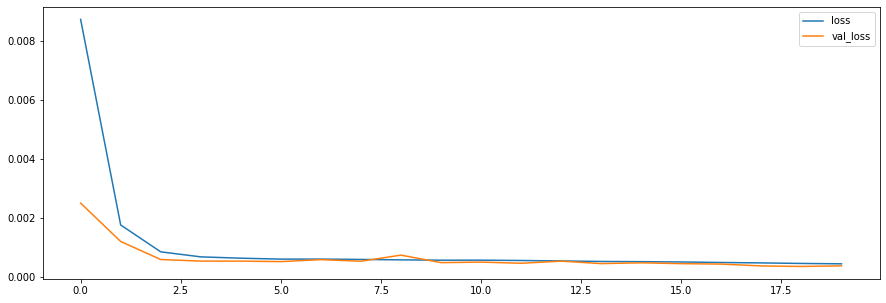

In [31]:
# 학습결과 시각화
plt.figure(figsize=(15,5))
plt.plot(h1.history['loss'], label='loss')
plt.plot(h1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### 모델예측 결과 시각화

In [32]:
result = test[['y+1']] # 테스트 데이터 정답 추출

In [33]:
result['pre'] = model.predict(X_test) # 모델의 예측결과를 컬럼으로 추가

46/46 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
result

,y+1,pre
timestamp,,
2014-11-01 00:00:00,0.140216,0.148739
2014-11-01 01:00:00,0.126656,0.137541
2014-11-01 02:00:00,0.124191,0.132623
2014-11-01 03:00:00,0.135593,0.150186
2014-11-01 04:00:00,0.166718,0.180274
...,...,...
2014-12-31 18:00:00,0.626502,0.612777
2014-12-31 19:00:00,0.578428,0.561266
2014-12-31 20:00:00,0.521418,0.524746


In [35]:
# 스케일링 한것을 원래 단위로 복원
result[['y+1','pre']] = scaler.inverse_transform(result)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [36]:
result

,y+1,pre
timestamp,,
2014-11-01 00:00:00,2434.0,2461.656734
2014-11-01 01:00:00,2390.0,2425.319662
2014-11-01 02:00:00,2382.0,2409.362270
2014-11-01 03:00:00,2419.0,2466.352610
2014-11-01 04:00:00,2520.0,2563.989935
...,...,...
2014-12-31 18:00:00,4012.0,3967.460381
2014-12-31 19:00:00,3856.0,3800.307606
2014-12-31 20:00:00,3671.0,3681.799419


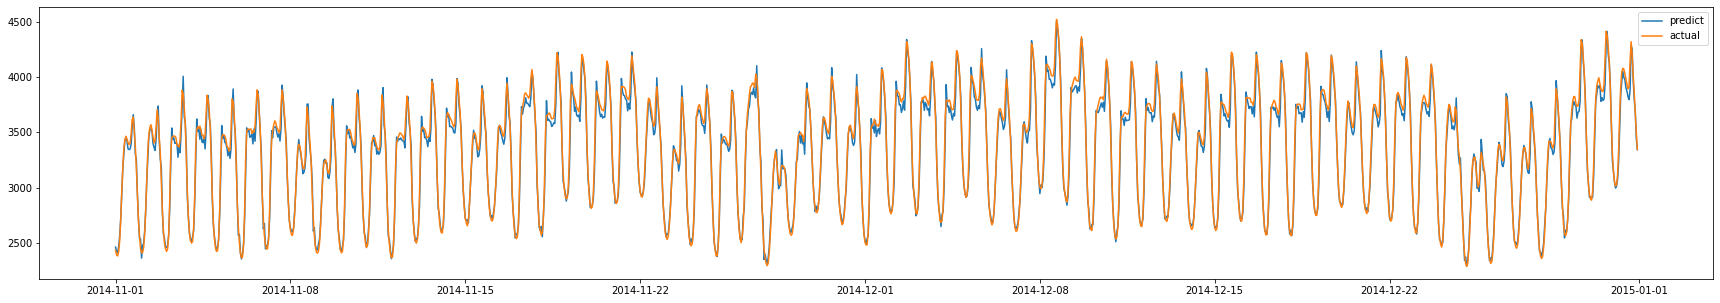

In [37]:
plt.figure(figsize=(30,5))
plt.plot(result['pre'], label='predict')
plt.plot(result['y+1'], label='actual')
plt.legend()
plt.show()

### load와 temp모두 고려해서 학습하기
- timestep = 6
- features = 2(에너지 사용량, 온도)
- shape = (s,6,2)
- 주의사항 : 1. 스케일링할때 load와 temp따로 스케일링하기(그래야 나중에 inverse_scaling을 load만 할 수 있다) <br>                    2. shift할때 loadt_5, tempt_5 이런순서로 해야 나중에 reshape 2로 할 수 있음


In [38]:
energy = pd.read_csv('./data/energy.csv',
                     parse_dates=['timestamp'],
                     index_col='timestamp')


In [41]:
# 스케일러 생성
load_scaler = MinMaxScaler()
temp_scaler = MinMaxScaler()
load_scaler.fit(energy[['load']])  # 2차원으로 넣어줌
temp_scaler.fit(energy[['temp']])
energy['load'] = load_scaler.transform(energy[['load']])
energy['temp'] = temp_scaler.transform(energy[['temp']])

In [43]:
energy.head()

,load,temp
timestamp,,
2012-01-01 00:00:00,0.221572,0.420245
2012-01-01 01:00:00,0.178428,0.426380
2012-01-01 02:00:00,0.143297,0.401840
2012-01-01 03:00:00,0.130354,0.411043
2012-01-01 04:00:00,0.130663,0.420245


In [45]:
# 과거 6시간으로 미래1시간을 예측
energy_shifted = energy.copy() # 데이터복사
energy_shifted['y+1'] = energy_shifted['load'].shift(-1,freq='H')
energy_shifted['load_t-5'] = energy['load'].shift(5,freq='H')
energy_shifted['temp_t-5'] = energy['temp'].shift(5,freq='H')
energy_shifted['load_t-4'] = energy['load'].shift(4,freq='H')
energy_shifted['temp_t-4'] = energy['temp'].shift(4,freq='H')
energy_shifted['load_t-3'] = energy['load'].shift(3,freq='H')
energy_shifted['temp_t-3'] = energy['temp'].shift(3,freq='H')
energy_shifted['load_t-2'] = energy['load'].shift(2,freq='H')
energy_shifted['temp_t-2'] = energy['temp'].shift(2,freq='H')
energy_shifted['load_t-1'] = energy['load'].shift(1,freq='H')
energy_shifted['temp_t-1'] = energy['temp'].shift(1,freq='H')
energy_shifted['load_t-0'] = energy['load'].shift(0,freq='H')
energy_shifted['temp_t-0'] = energy['temp'].shift(0,freq='H')


In [47]:
energy_shifted.head(10)

,load,temp,y+1,load_t-5,temp_t-5,load_t-4,temp_t-4,load_t-3,temp_t-3,load_t-2,temp_t-2,load_t-1,temp_t-1,load_t-0,temp_t-0
timestamp,,,,,,,,,,,,,,,
2012-01-01 00:00:00,0.221572,0.420245,0.178428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.221572,0.420245
2012-01-01 01:00:00,0.178428,0.426380,0.143297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.221572,0.420245,0.178428,0.426380
2012-01-01 02:00:00,0.143297,0.401840,0.130354,NaN,NaN,NaN,NaN,NaN,NaN,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840
2012-01-01 03:00:00,0.130354,0.411043,0.130663,NaN,NaN,NaN,NaN,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043
2012-01-01 04:00:00,0.130663,0.420245,0.146071,NaN,NaN,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245
2012-01-01 05:00:00,0.146071,0.414110,0.179045,0.221572,0.420245,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110
2012-01-01 06:00:00,0.179045,0.401840,0.228043,0.178428,0.426380,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840
2012-01-01 07:00:00,0.228043,0.392638,0.288752,0.143297,0.401840,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638
2012-01-01 08:00:00,0.288752,0.392638,0.346995,0.130354,0.411043,0.130663,0.420245,0.146071,0.414110,0.179045,0.401840,0.228043,0.392638,0.288752,0.392638


In [48]:
energy_shifted.dropna(inplace=True)

In [49]:
train = energy_shifted[energy_shifted.index < validation_start]
validation = energy_shifted[(energy_shifted.index >= validation_start) & (energy_shifted.index < test_start)]
test = energy_shifted[energy_shifted.index >= test_start]

In [50]:
# 훈련
X_train = train.loc[:,'load_t-5':'temp_t-0']
y_train = train['y+1']
# 검증
X_validation = validation.loc[:,'load_t-5':'temp_t-0']
y_validation = validation['y+1']
# 평가
X_test = test.loc[:,'load_t-5':'temp_t-0']
y_test = test['y+1']

In [51]:
# RNN을 위한 데이터 구조로 변경(samples, time-steps, features) 
X_train = X_train.values.reshape(-1,6,2)
X_validation = X_validation.values.reshape(-1,6,2)
X_test = X_test.values.reshape(-1,6,2)

In [52]:
model=Sequential()

model.add(InputLayer(input_shape=(6,2)))
model.add(LSTM(64))
model.add(Dense(1))

In [53]:
model.compile(loss='mean_squared_error', # 회귀모델
              optimizer='Adam')

In [54]:
h1 = model.fit(X_train,y_train,
               epochs=20,
               validation_data=(X_validation,y_validation))

Epoch 1/20
731/731 [==============================] - 7s 6ms/step - loss: 0.0079 - val_loss: 0.0020
Epoch 2/20
731/731 [==============================] - 4s 6ms/step - loss: 0.0012 - val_loss: 6.3333e-04
Epoch 3/20
731/731 [==============================] - 4s 6ms/step - loss: 7.5277e-04 - val_loss: 4.9208e-04
Epoch 4/20
731/731 [==============================] - 4s 6ms/step - loss: 6.0540e-04 - val_loss: 7.2418e-04
Epoch 5/20
731/731 [==============================] - 4s 6ms/step - loss: 5.6721e-04 - val_loss: 6.0301e-04
Epoch 6/20
731/731 [==============================] - 7s 10ms/step - loss: 5.6060e-04 - val_loss: 4.9287e-04
Epoch 7/20
731/731 [==============================] - 6s 9ms/step - loss: 5.4193e-04 - val_loss: 4.5597e-04
Epoch 8/20
731/731 [==============================] - 5s 7ms/step - loss: 5.2598e-04 - val_loss: 4.5369e-04
Epoch 9/20
731/731 [==============================] - 4s 5ms/step - loss: 5.2054e-04 - val_loss: 5.0109e-04
Epoch 10/20
731/731 [==================

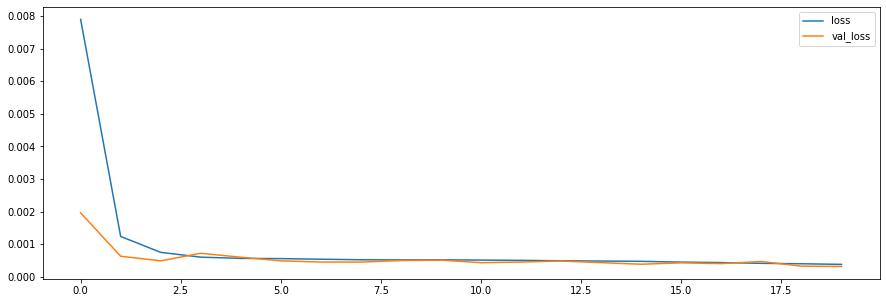

In [66]:
# 학습결과 시각화
plt.figure(figsize=(15,5))
plt.plot(h1.history['loss'], label='loss')
plt.plot(h1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [61]:
result = test[['y+1']] # 테스트 데이터 정답 추출
result['pre'] = model.predict(X_test) # 모델의 예측결과를 컬럼으로 추가

46/46 [==============================] - 0s 2ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
result

,y+1,pre
timestamp,,
2014-11-01 00:00:00,0.140216,0.139854
2014-11-01 01:00:00,0.126656,0.126743
2014-11-01 02:00:00,0.124191,0.126790
2014-11-01 03:00:00,0.135593,0.154425
2014-11-01 04:00:00,0.166718,0.189799
...,...,...
2014-12-31 18:00:00,0.626502,0.615858
2014-12-31 19:00:00,0.578428,0.562051
2014-12-31 20:00:00,0.521418,0.520304


In [64]:
# 스케일링 한것을 원래 단위로 복원
result['y+1'] = load_scaler.inverse_transform(result[['y+1']])
result['pre'] = load_scaler.inverse_transform(result[['pre']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


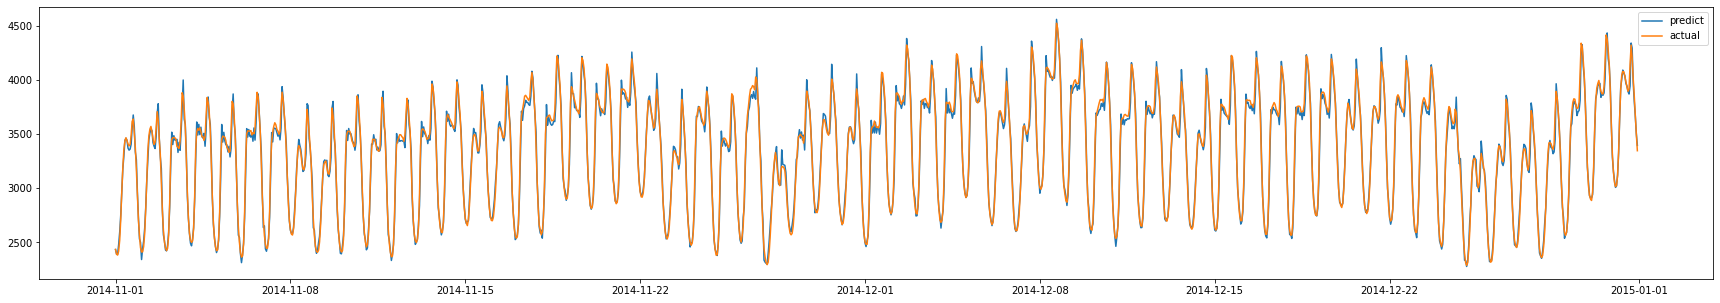

In [65]:
plt.figure(figsize=(30,5))
plt.plot(result['pre'], label='predict')
plt.plot(result['y+1'], label='actual')
plt.legend()
plt.show()